# Imports

In [1]:
import numpy as np
import pickle
import os
import re
import pandas as pd
from tqdm import tqdm
import glob
import networkx as nx

import sys
sys.path.append("../../scripts") # TODO: make this part of pythonpath?

import matplotlib.pyplot as plt

from scripts.run_bubblewrap import BubblewrapRun

In [2]:
all_inline = True

# Individual analysis

## Individial file discovery/loading

In [3]:
files = glob.glob("*pickle")
files.sort()
files[-10:]

['bubblewrap_run_2023-05-16-17-19-15.pickle',
 'bubblewrap_run_2023-05-16-17-19-44.pickle',
 'bubblewrap_run_2023-05-17-13-31-06.pickle',
 'bubblewrap_run_2023-05-17-13-31-32.pickle',
 'bubblewrap_run_2023-05-17-13-31-59.pickle',
 'bubblewrap_run_2023-05-30-11-19-47.pickle',
 'bubblewrap_run_2023-05-30-11-21-40.pickle',
 'bubblewrap_run_2023-05-30-11-22-46.pickle',
 'bubblewrap_run_2023-05-30-11-27-56.pickle',
 'bubblewrap_run_2023-05-30-11-28-56.pickle']

In [4]:
file = 'bubblewrap_run_2023-05-10-12-47-22.pickle'
file

'bubblewrap_run_2023-05-10-12-47-22.pickle'

In [5]:
with open(file, "rb") as fhan:
    br = pickle.load(fhan)
    if br.bw_parameters and "seed" not in br.bw_parameters:
        br.bw_parameters["seed"] = 42

In [6]:
for key, value in br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {br.file}")
print(f"savefile: {br.outfile}")
print(f"# of dead nodes: {len(br.dead_nodes)}")
print(f"# of steps: {br.entropy_list.shape[0]}")

num: 200
lam: 0.001
nu: 0.001
eps: 1e-05
step: 0.08
M: 30
B_thresh: -10
batch: False
batch_size: 1
go_fast: False
lookahead_steps: [1, 2, 3, 4, 5, 8, 10, 16, 32, 64, 128]
seed: 42
save_A: False
input file: ./generated/datasets/shuffled_neuropixel_reduced_10d.npy
savefile: generated/bubblewrap_runs/bubblewrap_run_2023-05-10-12-47-22.pickle
# of dead nodes: 0
# of steps: 74330


## Smoothed Entropy/Prop plot

In [91]:
def one_sided_ewma(data, com=100):
    return pd.DataFrame(data=dict(data=data)).ewm(com).mean()["data"]

def two_sided_ewma(data, half_width=75):
    kernel = np.linspace(0,10,half_width)
    kernel = np.exp(kernel)
    kernel = np.hstack((kernel, np.flip(kernel)))
    kernel = kernel/kernel.sum()
    return np.convolve(data, kernel, 'valid')

## $A$ graph analysis

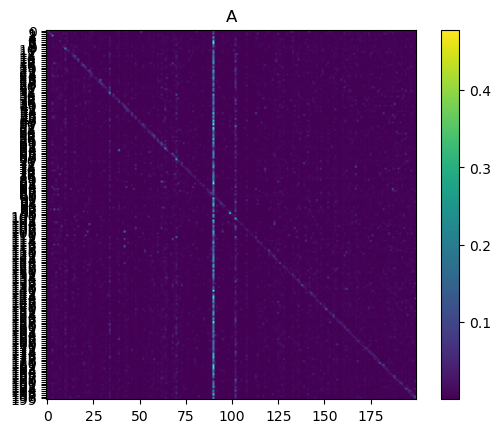

In [8]:
%matplotlib inline

fig, ax = plt.subplots()
im = ax.imshow(br.A)
ax.set_title("A")

live_nodes = [x for x in np.arange(br.bw_parameters["num"]) if x not in br.dead_nodes]
ax.set_yticks(live_nodes);
fig.colorbar(im)

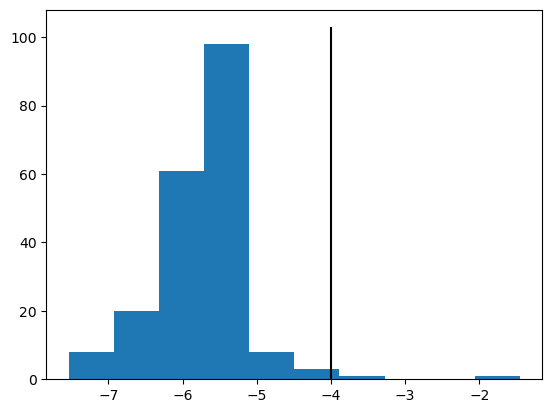

In [9]:
node_cutoff = -4

alphas = br.alpha_list[-br.alpha_list.shape[0]//4:,:]

fig, ax = plt.subplots()
counts, _, _ = ax.hist(np.log(alphas.mean(axis=0)))

ax.vlines([node_cutoff], ymin=0, ymax=counts.max()*1.05, color='k')

In [10]:
A = br.A
mask = alphas.mean(axis=0) > np.exp(node_cutoff)
A_less_nodes = A[mask]
A_less_nodes = A_less_nodes[:,mask]

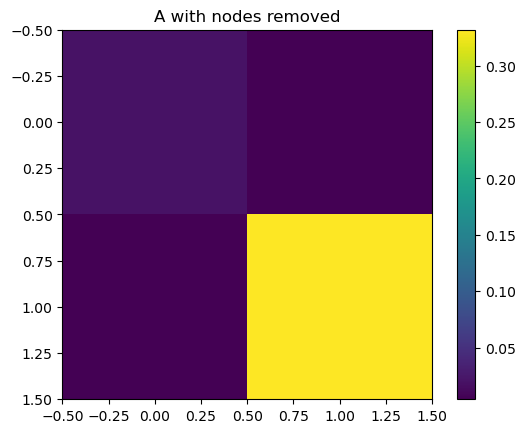

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(A_less_nodes)
ax.set_title("A with nodes removed")

fig.colorbar(im)

In [12]:
A_no_diagonals = np.array(A_less_nodes)
A_no_diagonals[np.diag_indices(A_no_diagonals.shape[0])] = 0

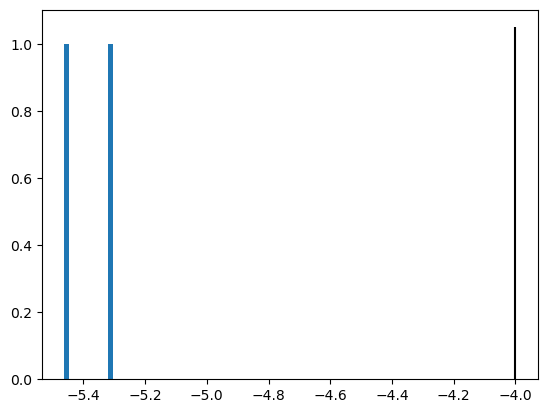

In [13]:
edge_cutoff = -4

fig, ax = plt.subplots()
counts, _, _ = ax.hist(np.log(A_no_diagonals[A_no_diagonals > 1e-10]))

ax.vlines([edge_cutoff], ymin=0, ymax=counts.max()*1.05, color='k')

In [14]:
A_less_edges = np.array(A_no_diagonals)
A_less_edges[A_less_edges < np.exp(edge_cutoff)] = 0

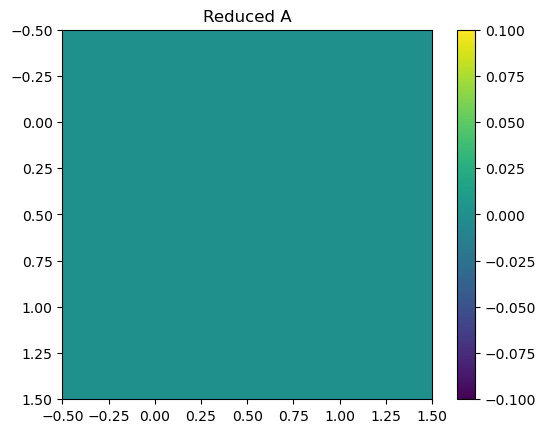

In [15]:
%matplotlib inline

fig, ax = plt.subplots()
im = ax.imshow(A_less_edges)
ax.set_title("Reduced A")
fig.colorbar(im)

In [16]:
A_few_edges_few_nodes =  np.array(A_less_edges)
mask = np.logical_or(A_less_edges.std(axis=0)>0, A_less_edges.std(axis=1)>0)
A_few_edges_few_nodes = A_few_edges_few_nodes[mask]
A_few_edges_few_nodes = A_few_edges_few_nodes[:,mask]

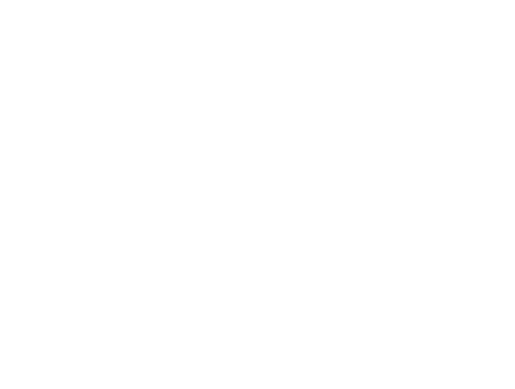

In [17]:
G = nx.from_numpy_array(A_few_edges_few_nodes, create_using = nx.DiGraph())

fig, ax = plt.subplots()
nx.draw_circular(G, with_labels=True)
# nx.draw_kamada_kawai(G, with_labels=True)
# nx.draw_planar(G, with_labels=True)
# nx.draw_random(G, with_labels=True)
# nx.draw_spectral(G, with_labels=True)
# nx.draw_spring(G, with_labels=True)
# nx.draw_shell(G, with_labels=True)

# Comparing new and old forcasting metrics

## Files

### Datasets definition

In [18]:
datasets = pd.DataFrame(columns=["old_way_file", "new_way_file", "shuffled_old_way_file", "shuffled_new_way_file", "has_A", "has_states"])

In [19]:
datasets.loc['clock fast'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-11-48-30.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-11-49-13.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-40-32.pickle',
        has_A = True,
        has_states = True,
    )

datasets.loc['clock slow'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-11-50-01.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-11-50-47.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-39-30.pickle',
        has_A = True,
        has_states = True,
    )

datasets.loc['clock halfspeed'] = \
    dict(
        old_way_file = "bubblewrap_run_2023-04-27-11-39-10.pickle",
        new_way_file = "bubblewrap_run_2023-04-27-11-39-52.pickle",
        shuffled_old_way_file = "bubblewrap_run_2023-04-27-11-40-41.pickle",
        shuffled_new_way_file = "bubblewrap_run_2023-04-27-11-41-28.pickle",
        has_A = True,
        has_states = True,
    )


datasets.loc['monkey reach'] = \
    dict(
        old_way_file = "bubblewrap_run_2023-04-27-11-41-57.pickle",
        new_way_file = "bubblewrap_run_2023-04-27-11-42-12.pickle",
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-41-05.pickle',
        has_A = True,
        has_states = False,
    )

datasets.loc['neuropixel short'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-12-22-38.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-12-22-44.pickle',
        has_A = True,
        has_states = False,
    )

datasets.loc['mouse short'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-12-23-43.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-12-24-36.pickle',
        has_A = True,
        has_states = False,
    )


datasets.loc['widefield short'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-12-25-31.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-12-26-25.pickle',
        has_A = True,
        has_states = False,
    )

datasets.loc['neuropixel'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-14-55-21.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-15-01-37.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-49-17.pickle',
        has_A = False,
        has_states = False,
    )


datasets.loc['mouse 200'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-15-09-55.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-15-18-06.pickle',
        has_A = False,
        has_states = False,
    )


datasets.loc['widefield'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-04-27-15-25-37.pickle',
        new_way_file = 'bubblewrap_run_2023-04-27-15-32-54.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-02-17-58-25.pickle',
        has_A = False,
        has_states = False,
    )


datasets.loc['mouse 1k'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-05-01-17-20-24.pickle',
        new_way_file = 'bubblewrap_run_2023-05-01-18-24-38.pickle',
        has_A = False,
        has_states = False,
    )

datasets.loc['mouse short'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-05-02-17-22-19.pickle',
        new_way_file = 'bubblewrap_run_2023-05-03-09-27-01.pickle',
        has_A = False,
        has_states = False,

    )

datasets.loc['mouse'] = \
    dict(
        old_way_file = 'bubblewrap_run_2023-05-03-14-56-18.pickle',
        new_way_file ='bubblewrap_run_2023-05-03-15-16-01.pickle',
        shuffled_new_way_file = 'bubblewrap_run_2023-05-03-16-14-39.pickle',
        has_A = False,
        has_states = False,
    )



In [20]:
def assert_brs_match(brs):
    for i in range(len(brs)-1):
        assert brs[i].bw_parameters == brs[i+1].bw_parameters

for dataset in datasets.index:
    br_s = []
    for column in [column for column in datasets if "file" in column]:
        if not pd.isna(datasets.loc[dataset, column]):
            with open(datasets.loc[dataset, column], "rb") as fhan:
                br = pickle.load(fhan)
            br_s.append(br)
    assert_brs_match(br_s)

### Dataset loading

In [21]:
dataset = 'monkey reach'

with open(datasets.loc[dataset].new_way_file, "rb") as fhan:
    new_way_br = pickle.load(fhan)

with open(datasets.loc[dataset].old_way_file, "rb") as fhan:
    old_way_br = pickle.load(fhan)

shuffled_br = None
if not pd.isna(datasets.loc[dataset].shuffled_new_way_file):
    with open(datasets.loc[dataset].shuffled_new_way_file, "rb") as fhan:
        shuffled_br = pickle.load(fhan)


    
states = None
if datasets.loc[dataset].has_states:
    states = np.load("../datasets/"+new_way_br.file.split("/")[-1])["x"]

In [22]:
for key, value in new_way_br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {new_way_br.file}")
print(f"savefile: {new_way_br.outfile}")
print(f"# of dead nodes: {len(new_way_br.dead_nodes)}")
print(f"# of steps: {new_way_br.entropy_list.shape[0]}")

num: 200
lam: 0.001
nu: 0.001
eps: 0.001
step: 0.08
M: 30
B_thresh: -10
batch: False
batch_size: 1
go_fast: False
lookahead_steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 32, 35, 40, 50, 64, 80, 100, 128, 256, 512]
seed: 42
save_A: True
input file: ./generated/jpca_reduced.npy
savefile: generated/bubblewrap_runs/bubblewrap_run_2023-04-27-11-42-12.pickle
# of dead nodes: 166
# of steps: 2268


In [23]:
assert new_way_br.bw_parameters.items() == old_way_br.bw_parameters.items()
assert np.all(new_way_br.entropy_list == old_way_br.entropy_list)
assert np.all((new_way_br.pred_list == old_way_br.pred_list)[:,0])
assert new_way_br.bw_parameters["lookahead_steps"] == old_way_br.bw_parameters["lookahead_steps"]
assert np.all(new_way_br.A == old_way_br.A)
print((new_way_br.pred_list == old_way_br.pred_list)[:,1:].mean())

0.0004232804232804233


## A Inspection

### A History (optional)

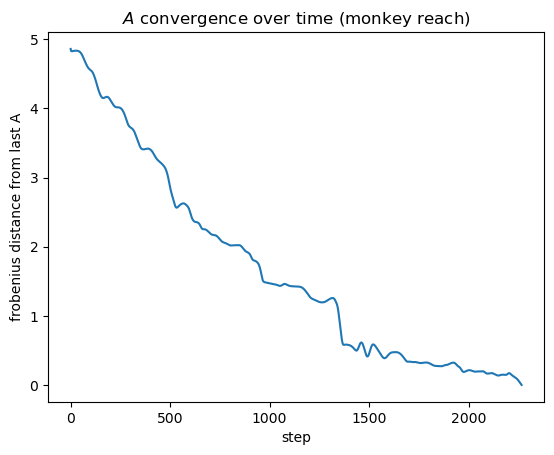

In [24]:
%matplotlib inline
if datasets.loc[dataset].has_A:
    plt.plot(np.linalg.norm(new_way_br.A_list - new_way_br.A_list[-1], axis=(1,2)))
    plt.xlabel("step")
    plt.ylabel("frobenius distance from last A")
    plt.title(f"$A$ convergence over time ({dataset})");

In [25]:
if datasets.loc[dataset].has_A:
    AA = new_way_br.A_list
    A_differences = np.zeros((AA.shape[0], AA.shape[0]))
    for i in tqdm(range(AA.shape[0])):
        for j in range(AA.shape[0]):
            A_differences[i,j] = np.linalg.norm(AA[i] - AA[j])
            A_differences[j,i] = A_differences[i,j]


100%|███████████████████████████████████████| 2268/2268 [02:04<00:00, 18.22it/s]


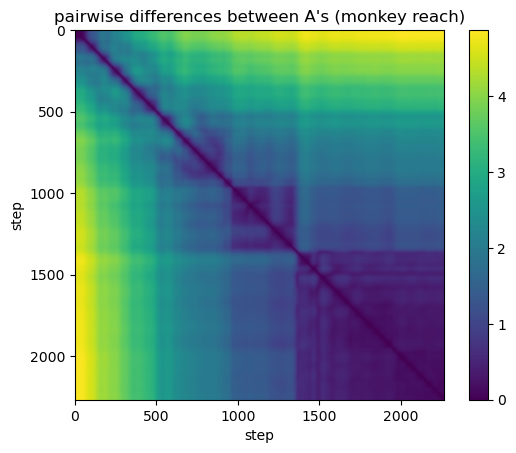

In [26]:
if datasets.loc[dataset].has_A:

    plt.imshow((A_differences))
    plt.title(f"pairwise differences between A's ({dataset})")
    plt.xlabel("step")
    plt.ylabel("step")

    plt.colorbar();

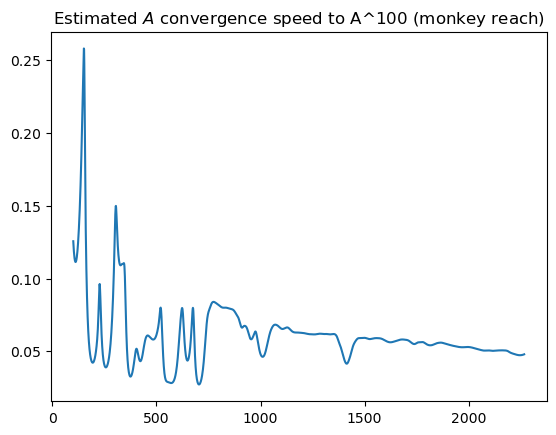

In [29]:
if datasets.loc[dataset].has_A:
    %matplotlib inline
    def get_slope(a):
        power = 20
        a_final = np.linalg.matrix_power(a, 100)
        current = a
        distances = []
        for _ in range(power+1):
            distances.append(np.linalg.norm(current - a_final))
            current = current @ a
        d = np.diff(np.log(distances))


        return d[10:].mean()

    plt.figure()
    slopes = []
    end = AA.shape[0]
    start = 100
    for i in range(start,end):
        slopes.append(get_slope(AA[i]))
    slopes = np.array(slopes)
    plt.plot(np.arange(start,end),-slopes)
    plt.title(f"Estimated $A$ convergence speed to A^100 ({dataset})");

### Current A

Text(0, 0.5, 'eigenvalue')

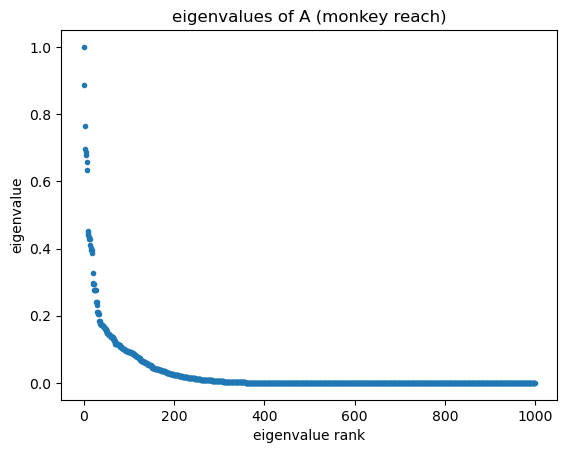

In [30]:
# s = np.sort(np.abs(np.linalg.eigvals(old_way_br.A)))[::-1]
s = np.sort(np.abs(np.linalg.eigvals(br.A)))[::-1]
plt.plot(s,'.')
plt.title(f"eigenvalues of A ({dataset})")
plt.xlabel("eigenvalue rank")
plt.ylabel("eigenvalue")

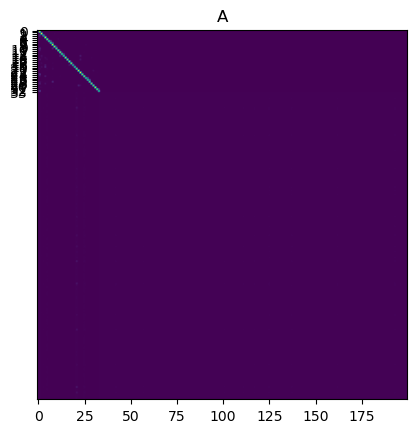

In [31]:
if not all_inline:
    %matplotlib qt
    
fig, ax = plt.subplots()
ax.imshow(new_way_br.A)
ax.set_title("A")

live_nodes = [x for x in np.arange(new_way_br.bw_parameters["num"]) if x not in new_way_br.dead_nodes]
ax.set_yticks(live_nodes);


## Prediction History

### On average

#### Average performance by steps_ahead

In [32]:
# calculates for the next cell

T = new_way_br.pred_list.shape[0]
new_way_means = []
old_way_means = []
shuffled_means = []

new_way_stds = []
old_way_stds = []
shuffled_stds = []
for i, step in enumerate(new_way_br.bw_parameters["lookahead_steps"]):
    first_nonzero = np.nonzero(np.isnan(new_way_br.pred_list[:,i]))[0]
    if len(first_nonzero):
        local_T = first_nonzero[0]
    else:
        local_T = T
    new_way_means.append(np.mean(new_way_br.pred_list[-local_T//2:local_T,i]))
    new_way_stds.append(np.std(new_way_br.pred_list[-local_T//2:local_T,i], ddof=1))
    # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")

for i, step in enumerate(old_way_br.bw_parameters["lookahead_steps"]):
    old_way_means.append(np.mean(old_way_br.pred_list[-T//2:,i]))
    old_way_stds.append(np.std(old_way_br.pred_list[-T//2:,i], ddof=1))
    # print(f"old way {step:>2} step(s) ahead mean: {old_way_means[-1]}")

if shuffled_br is not None:
    for i, step in enumerate(shuffled_br.bw_parameters["lookahead_steps"]):
        first_nonzero = np.nonzero(np.isnan(shuffled_br.pred_list[:,i]))[0]
        if len(first_nonzero):
            local_T = first_nonzero[0]
        else:
            local_T = T
        shuffled_means.append(np.mean(shuffled_br.pred_list[-local_T//2:local_T,i]))
        shuffled_stds.append(np.std(shuffled_br.pred_list[-local_T//2:local_T,i], ddof=1))
        # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")


new_way_means = np.array(new_way_means)
old_way_means = np.array(old_way_means)

new_way_stds = np.array(new_way_stds)
old_way_stds = np.array(old_way_stds)

if shuffled_br is not None:
    shuffled_stds = np.array(shuffled_stds)
    shuffled_means = np.array(shuffled_means)

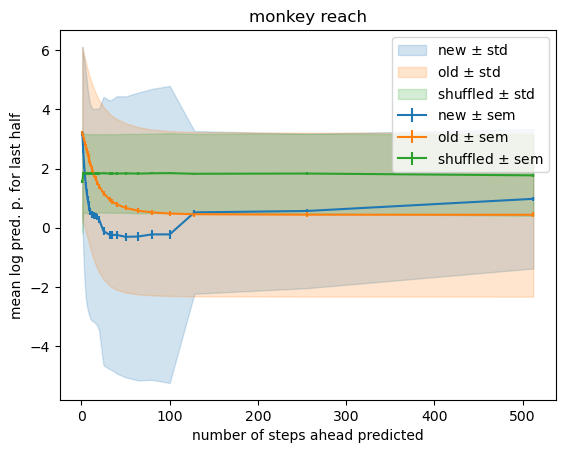

In [33]:
# plots averages across step numbers
if not all_inline:
    %matplotlib qt
    
plt.figure()
plt.errorbar(new_way_br.bw_parameters["lookahead_steps"], new_way_means, new_way_stds/np.sqrt(T/2))
plt.errorbar(new_way_br.bw_parameters["lookahead_steps"], old_way_means, old_way_stds/np.sqrt(T/2),)
if shuffled_br is not None:
    plt.errorbar(new_way_br.bw_parameters["lookahead_steps"], shuffled_means, shuffled_stds/np.sqrt(T/2),)
plt.fill_between(new_way_br.bw_parameters["lookahead_steps"], new_way_means - new_way_stds,new_way_means+ new_way_stds, color="C0", alpha=0.2)
plt.fill_between(new_way_br.bw_parameters["lookahead_steps"], old_way_means - old_way_stds,old_way_means+ old_way_stds, color="C1", alpha=0.2)
if shuffled_br is not None:
    plt.fill_between(new_way_br.bw_parameters["lookahead_steps"], shuffled_means - shuffled_stds,shuffled_means+ shuffled_stds, color="C2", alpha=0.2)
    plt.legend(["new $\pm$ std", "old $\pm$ std","shuffled $\pm$ std","new $\pm$ sem", "old $\pm$ sem", "shuffled $\pm$ sem"])
else:
    plt.legend(["new $\pm$ std", "old $\pm$ std", "new $\pm$ sem", "old $\pm$ sem"])
plt.ylabel("mean log pred. p. for last half")
plt.xlabel("number of steps ahead predicted")
plt.title(f"{dataset}");

### Over Time

#### Tune smoothing factor

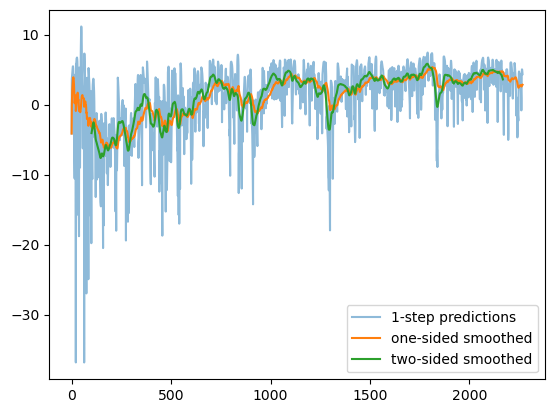

In [34]:
if not all_inline:
    %matplotlib qt


data = old_way_br.pred_list[:,0]
smoothed_data1 = one_sided_ewma(data,40)

plt.plot(data, alpha=.5)
plt.plot(smoothed_data1);

half_width = 100
smoothed_data2 = two_sided_ewma(data,half_width)
plt.plot(np.arange(smoothed_data2.size) + half_width, smoothed_data2);

plt.legend(["1-step predictions", "one-sided smoothed", "two-sided smoothed"]);

#### Smoothed Predictions and alpha

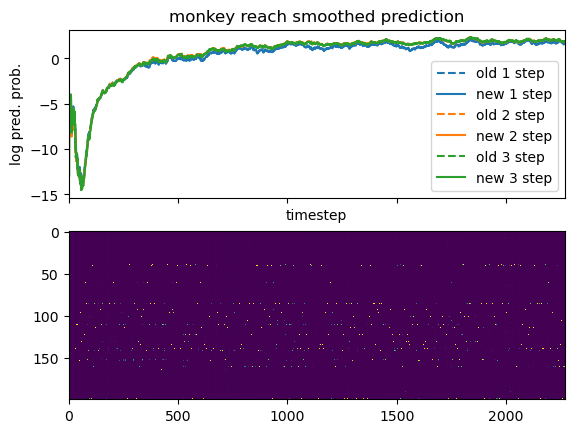

In [35]:
# shows smoothed predictions over time

if not all_inline:
    %matplotlib qt
    
show_states_instead_of_alpha = True

smoothing_scale = 40
br = shuffled_br

fig, axs = plt.subplots(2,1, sharex=True)
steps = [1,2,3]
for si, step in enumerate(steps):
    i = br.bw_parameters["lookahead_steps"].index(step)
    old_pred = br.pred_list[:,i]
    new_pred = br.pred_list[:,i]
    # plt.plot(pred)


    smoothed_old_pred = one_sided_ewma(old_pred, smoothing_scale)
    smoothed_new_pred = one_sided_ewma(new_pred, smoothing_scale)
    half_width = 0 # NOTE: set this if you use the two-sided ewma function
    
    axs[0].plot(np.arange(smoothed_old_pred.size) + half_width, smoothed_old_pred, color=f'C{si}', linestyle='dashed')
    x_correction = (step-1)*1
    axs[0].plot(np.arange(smoothed_new_pred.size) + half_width + x_correction,smoothed_new_pred, color=f'C{si}',linestyle='solid')

legend = []
for step in steps:
    legend.append(f"old {step} step")
    legend.append(f"new {step} step")
axs[0].legend(legend)
axs[0].set_title(f"{dataset} smoothed prediction")
axs[0].set_xlabel("timestep")
axs[0].set_ylabel("log pred. prob.");



if states is not None and show_states_instead_of_alpha:
    axs[1].plot(states,'.')
else:
    alpha = br.alpha_list.T
    state_means = alpha.mean(axis=1)
    # alpha = alpha[state_means > np.quantile(state_means, .75),:]
    alpha = alpha[np.argsort(-alpha.mean(axis=1)) - (alpha.shape[0]//2),:]
    axs[1].imshow((alpha), aspect="auto", interpolation="nearest")
# axs[0].set_xlim([500, 1000])

#### Smoothed predictions and entropy

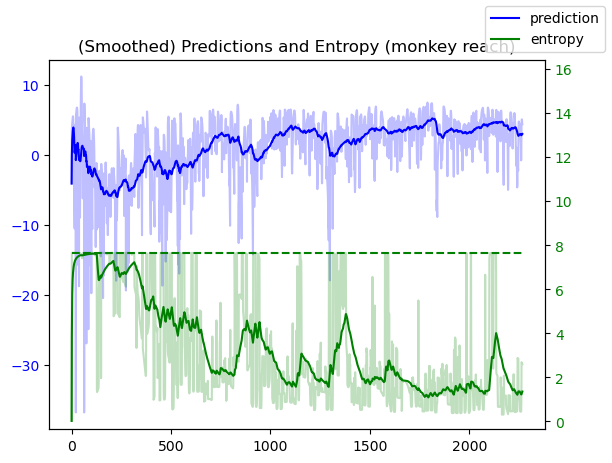

In [36]:
# shows smoothed predictions and entropy
if not all_inline:
    %matplotlib qt

    
br = new_way_br

smooting_scale = 50

predictions = br.pred_list[:,0]
smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

fig, ax1 = plt.subplots()
ax1.plot(predictions, alpha=0.25, color='blue')
ax1.plot(smoothed_predictions, color='blue', label = "prediction")
ax1.tick_params(axis='y',labelcolor='blue')
ax1.set_title(f"(Smoothed) Predictions and Entropy ({dataset})")


entropy = br.entropy_list[:,0]
smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
ax2 = ax1.twinx()
ax2.plot(entropy, color='green', alpha=0.25)
ax2.plot(smoothed_entropy, color='green', label="entropy")
max_entropy = np.log2(br.bw_parameters["num"])
ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
ax2.tick_params(axis='y',labelcolor='green')
ymin, ymax = ax2.get_ylim()
ax2.set_ylim((ymin, 2*(ymax-ymin) + ymin))

fig.legend()

## State-prediction link

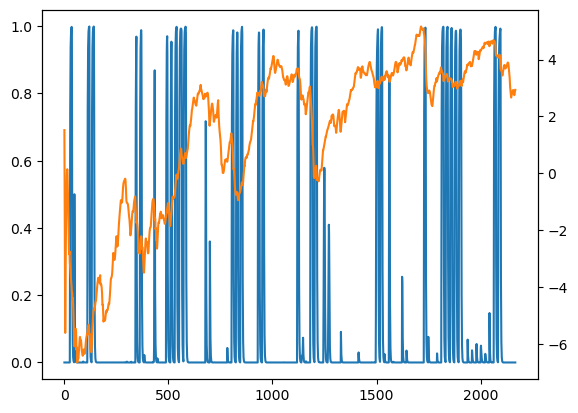

In [37]:
if not all_inline:
    %matplotlib qt

fig, ax1 = plt.subplots()
    
alpha = alpha = new_way_br.alpha_list.T

early_clip = 100

biggest_state = alpha[np.argmax(alpha.mean(axis=1)),:]
smoothed_biggest_state = one_sided_ewma(biggest_state[early_clip:], 1)
ax1.plot(smoothed_biggest_state, alpha=1)


ax2 = ax1.twinx()
new_pred = new_way_br.pred_list[:,0]
smoothed_new_pred = one_sided_ewma(new_pred[early_clip:], 50)
ax2.plot(smoothed_new_pred, color="C1", alpha=1)

In [38]:
np.corrcoef(smoothed_biggest_state[smoothed_biggest_state.shape[0]//2:], smoothed_new_pred[smoothed_new_pred.shape[0]//2:])[0,1]

-0.049300648880807124

## Dataset

### Loading the data

In [39]:
def get_dataset_from_file(file):
    f =  file.split("/")[-1]
    f = "neuropixel_reduced_10d.npy" if f == "neuropixel_reduced.npz" else f
    data = np.load("../datasets/" +f)
    data = data.T if "npy" in f else data["y"][0]
    return data

In [41]:
data = get_dataset_from_file(new_way_br.file)

### Pairwise distances

In [49]:
def ac1(data, shift=1):
    x = data - data.mean(axis=0)
    T = x.shape[0]

    # precision = np.linalg.inv(np.cov(x.T))
    precision = np.eye(x.shape[1])
    total = 0
    differences = x[0:T-shift] - x[shift:T]
    for i in range(differences.shape[0]):
        total += np.sqrt(differences[i] @ precision @ differences[i])
    total /= (T-shift)
    return total

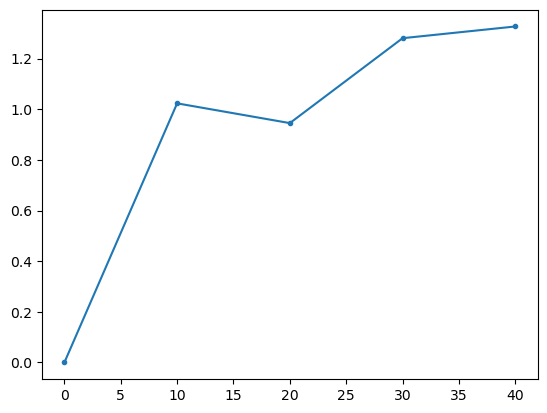

In [50]:
if not all_inline:
    %matplotlib qt
def mean_distance(data, shift=1):
    x = data - data.mean(axis=0)
    T = x.shape[0]
    
    differences = x[0:T-shift] - x[shift:T]
    distances = np.linalg.norm(differences,axis=1)
    
    return distances.mean()

x = np.arange(0,50,10)
plt.plot(x,[mean_distance(data,shift) for shift in x], '.-')

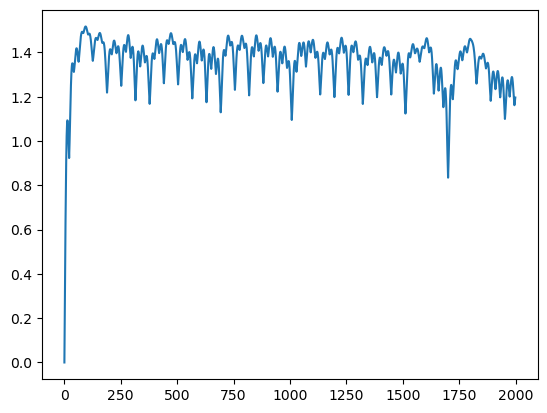

In [51]:
x = np.arange(2000)
plt.plot(x,[ac1(data, shift) for shift in x])

### Autocorrelation

In [52]:
def autocorr(data, shift=1):
    x = data - data.mean(axis=0)
    T = x.shape[0]
    
    behind = x[0:T-shift,:] 
    ahead = x[shift:T,:]
    total = np.zeros((x.shape[1], x.shape[1]))
    for i in range(T-shift):
        total = total + behind[i,:,None] @ ahead[None,i,:]
    total = total/ (T-shift) #ddof ?
    

    behind_std = 1/np.std(behind, axis=0, ddof=1)[:,None]
    ahead_std = 1/np.std(ahead, axis=0, ddof=1)[None,:]
    total = behind_std * total * ahead_std
    return total

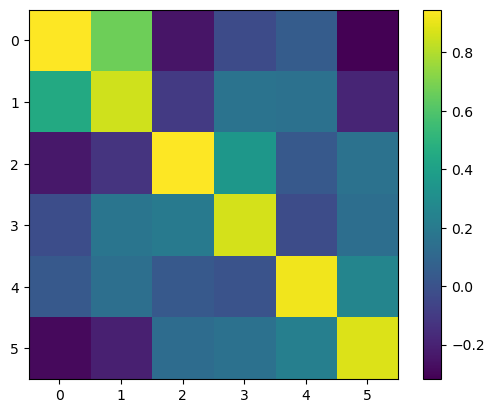

In [53]:
fig, ax = plt.subplots()
c = autocorr(data,2)
im = ax.imshow(c)
fig.colorbar(im);

0.1584647719274879

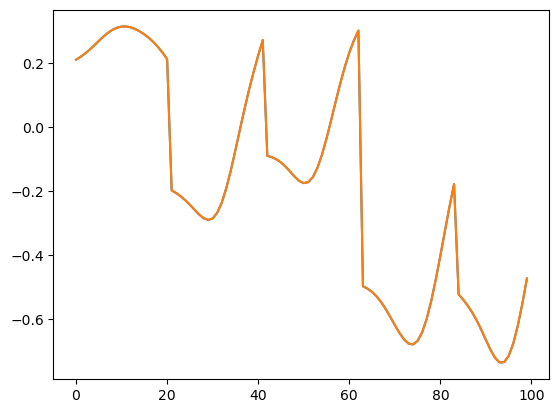

In [54]:
x = data - data.mean(axis=0)
shift = 0
T = 100
behind = x[0:T-shift,0]
ahead = x[shift:T,0]
plt.plot(behind)
plt.plot(ahead)
(behind * ahead).sum() / (T-shift-1)

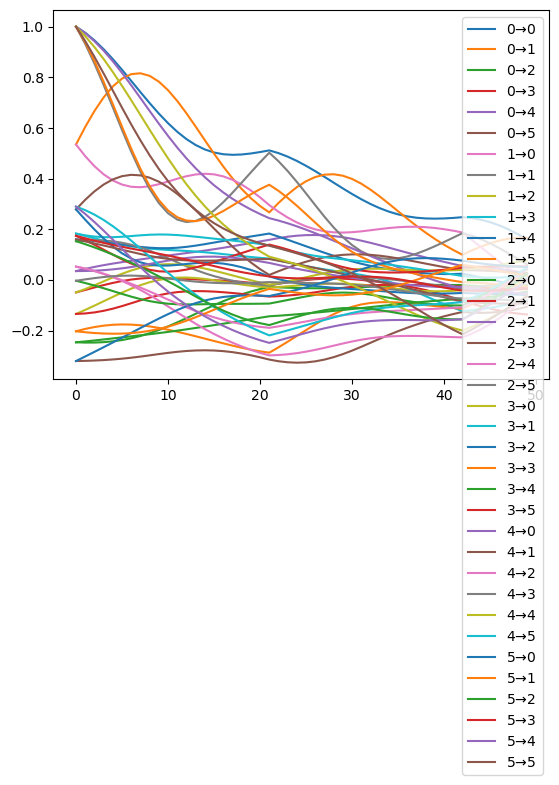

In [55]:
x = np.arange(50)
covs = []
for i in x:
    covs.append(autocorr(data,i))
covs = np.array(covs)

for c, (i,j) in enumerate(np.ndindex(covs.shape[1:])):
    trace = covs[:,i,j]
    if False:
        trace = trace - trace.min()
        trace = trace / trace.max()
        trace = trace + c
    plt.plot(trace, label=f"{i}$\\to${j}")
plt.legend()

# All-dataset comparisons

In [56]:
to_look_at_with_shuffles = np.array([['clock fast', 'clock slow', 'clock halfspeed', 'clock halfspeed shuffled'],['neuropixel','mouse', 'monkey reach', 'widefield', ],['neuropixel shuffled','mouse shuffled', 'monkey reach shuffled', 'widefield shuffled', ],])
to_look_at = np.array([['clock fast', 'clock slow', 'clock halfspeed', 'clock halfspeed shuffled'],['neuropixel','mouse', 'monkey reach', 'widefield', ],])

In [57]:
to_look_at_with_shuffles.shape

(3, 4)

In [58]:
def plot_for_datasets(to_look_at, plot_function):
    fig, axes = plt.subplots(ncols=to_look_at.shape[1], nrows=to_look_at.shape[0], layout='tight')
    if len(axes.shape) == 1:
        axes = axes[None,:]

    for i, j in np.ndindex(to_look_at.shape):
        if to_look_at[i,j] is None:
            continue
        if "shuffle" not in to_look_at[i,j]:
            with open(datasets.loc[to_look_at[i,j]].new_way_file, "rb") as fhan:
                br = pickle.load(fhan)
        else:
            dataset = " ".join(to_look_at[i,j].split(" ")[:-1])
            with open(datasets.loc[dataset].shuffled_new_way_file, "rb") as fhan:
                br = pickle.load(fhan)
        plot_function(br, axes[i,j], to_look_at[i,j])



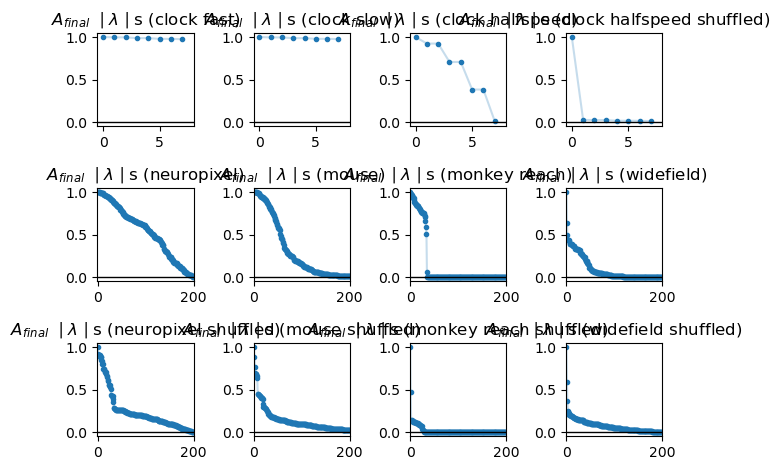

In [59]:
def plot_eigs(br, ax, name):
        e = np.abs(np.linalg.eigvals(br.A))
        ax.plot(np.sort(e)[::-1], '.')
        ax.plot(np.sort(e)[::-1], color="C0", alpha=0.25)
        ax.set_title("$A_{final}$ $\mid \\lambda \mid$s"+ f" ({name})")
        ax.set_ylim([-0.05,1.05])
        xlim = [-0.5,min(200, e.size)]
        ax.set_xlim(xlim)
        ax.hlines(0, *xlim, 'k', linewidth=1)
        
plot_for_datasets(to_look_at_with_shuffles, plot_eigs)

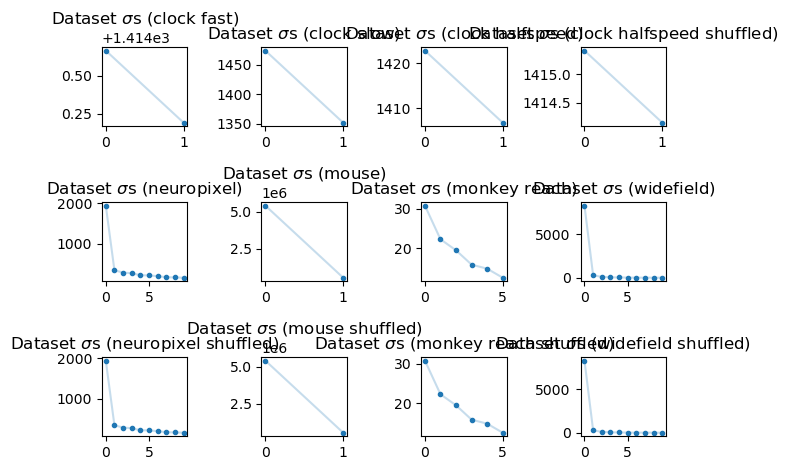

In [60]:
def plot_sings(br, ax, name):
    data = get_dataset_from_file(br.file)
    _,s,_ = np.linalg.svd(data, full_matrices=False)
    ax.plot(np.sort(s)[::-1], '.')
    ax.plot(np.sort(s)[::-1], color="C0", alpha=0.25)
    ax.set_title("Dataset $\\sigma$s"+ f" ({name})")
        
plot_for_datasets(to_look_at_with_shuffles, plot_sings)

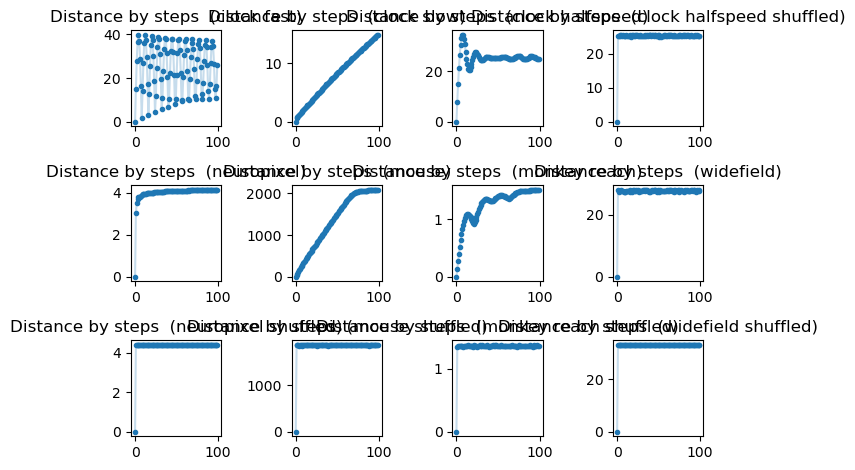

In [61]:
if not all_inline:
    %matplotlib qt
def plot_step_distances(br, ax, name):
    data = get_dataset_from_file(br.file)
    x = np.arange(100)
    distances = [mean_distance(data, shift) for shift in x]
    ax.plot(x, distances, '.')
    ax.plot(x, distances, color="C0", alpha=0.25)
    ax.set_title("Distance by steps "+ f" ({name})")
        
plot_for_datasets(to_look_at_with_shuffles, plot_step_distances)

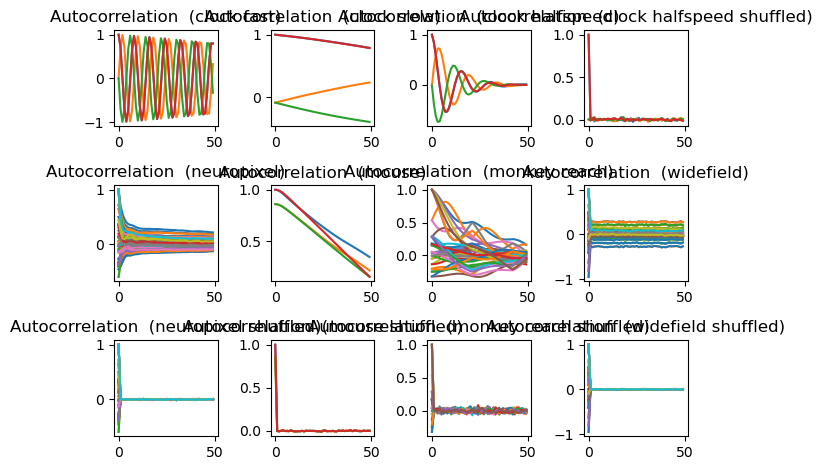

In [62]:
if not all_inline:
    %matplotlib qt
def plot_step_distances(br, ax, name):
    data = get_dataset_from_file(br.file)
    x = np.arange(50)
    covs = []
    for i in x:
        covs.append(autocorr(data,i))
    covs = np.array(covs)

    for c, (i,j) in enumerate(np.ndindex(covs.shape[1:])):
        trace = covs[:,i,j]
        if False:
            trace = trace - trace.min()
            trace = trace / trace.max()
            trace = trace + c
        ax.plot(trace, label=f"{i}$\\to${j}")
    ax.set_title("Autocorrelation "+ f" ({name})")
        
plot_for_datasets(to_look_at_with_shuffles, plot_step_distances)

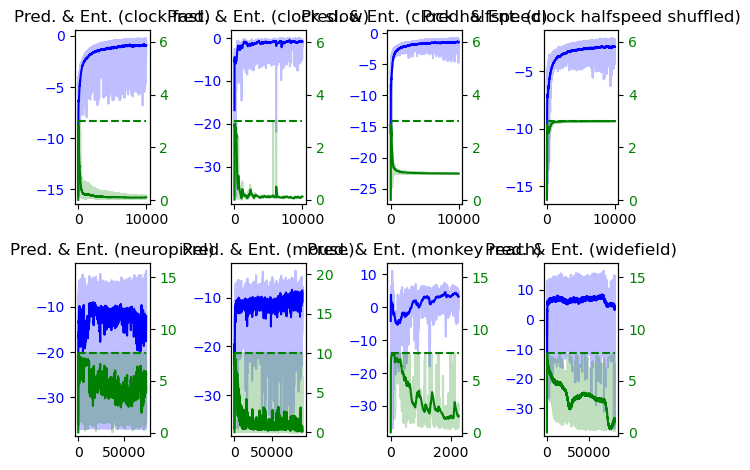

In [63]:
if not all_inline:
    %matplotlib qt
def figure_5(br, ax, name):
    smooting_scale = 100

    predictions = br.pred_list[:,0]
    smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

    ax.plot(predictions, alpha=0.25, color='blue')
    ax.plot(smoothed_predictions, color='blue', label = "prediction")
    ax.tick_params(axis='y',labelcolor='blue')
    ax.set_title(f"Pred. & Ent. ({name})")


    entropy = br.entropy_list[:,0]
    smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
    ax2 = ax.twinx()
    ax2.plot(entropy, color='green', alpha=0.25)
    ax2.plot(smoothed_entropy, color='green', label="entropy")
    max_entropy = np.log2(br.bw_parameters["num"])
    ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
    ax2.tick_params(axis='y',labelcolor='green')
    ymin, ymax = ax2.get_ylim()
    ax2.set_ylim((ymin, 2*(ymax-ymin) + ymin))
        
plot_for_datasets(to_look_at, figure_5)

In [120]:
if not all_inline:
    %matplotlib qt
def compare_figure_5(br, ax, name):
    smooting_scale = 100

    predictions = br.pred_list[:,0]
    smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

    ax.plot(predictions, alpha=0.25, color='blue')
    ax.plot(smoothed_predictions, color='blue', label = "prediction")
    ax.tick_params(axis='y',labelcolor='blue')
    ax.set_title(f"Pred. & Ent. ({name})")


    entropy = br.entropy_list[:,0]
    smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
    ax2 = ax.twinx()
    ax2.plot(entropy, color='green', alpha=0.25)
    ax2.plot(smoothed_entropy, color='green', label="entropy")
    max_entropy = np.log2(br.bw_parameters["num"])
    ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
    ax2.tick_params(axis='y',labelcolor='green')
    ymin, ymax = ax2.get_ylim()
    ax2.set_ylim((ymin, 2*(ymax-ymin) + ymin))

def plot_preds(name, ax):
    datasets.loc[name].new_way_file
    with open(datasets.loc[name].new_way_file, "rb") as fhan:
        br = pickle.load(fhan)
    prediction = br.pred_list[:,0]
    ax.plot(prediction, color='blue', alpha=0.25)
    ax.plot(one_sided_ewma(prediction), color='black', label='unshuffled')
    
    with open(datasets.loc[name].shuffled_new_way_file, "rb") as fhan:
        br = pickle.load(fhan)
    prediction = br.pred_list[:,0]
    ax.plot(prediction, color='blue', alpha=0.25)
    ax.plot(one_sided_ewma(prediction), color='blue', label='shuffled')
    

def plot_ents(name, ax):
    datasets.loc[name].new_way_file
    with open(datasets.loc[name].new_way_file, "rb") as fhan:
        br = pickle.load(fhan)
    entropy = br.entropy_list[:,0]
    ax.plot(entropy, color='green', alpha=0.25)
    ax.plot(one_sided_ewma(entropy), color='black', label='unshuffled')
    with open(datasets.loc[name].shuffled_new_way_file, "rb") as fhan:
        br = pickle.load(fhan)
    entropy = br.entropy_list[:,0]
    ax.plot(entropy, color='green', alpha=0.25)
    ax.plot(one_sided_ewma(entropy), color='green', label='shuffled')
    max_entropy = np.log2(br.bw_parameters["num"])
    ax.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')

        
        
fig, axs = plt.subplots(ncols=5, nrows=2)

plot_preds('neuropixel', axs[0,0])
axs[0,0].set_title('neuropixel')

plot_preds('mouse', axs[0,1])
axs[0,1].set_title('mouse')

plot_preds('monkey reach', axs[0,2])
axs[0,2].set_title('jpca')

plot_preds('widefield', axs[0,3])
axs[0,3].set_title('widefield')

plot_preds('clock halfspeed', axs[0,4])
axs[0,4].set_title('clock halfspeed')




plot_ents('neuropixel', axs[1,0])
plot_ents('mouse', axs[1,1])
plot_ents('monkey reach', axs[1,2])
plot_ents('widefield', axs[1,3])
plot_ents('clock halfspeed', axs[1,4])

    

axs[0,0].set_ylabel("Prediction")
axs[1,0].set_ylabel("Entropy")
    
axs[1,0].legend()
axs[0,0].legend()



In [76]:
datasets.loc['clock fast'].new_way_file

'bubblewrap_run_2023-04-27-11-49-13.pickle'

# Figuring out figure 5

In [ ]:
files = glob.glob("*pickle")
files.sort()
files = files[-20:]
files

In [ ]:
def plot_figure_5(brs):
    ps = [br.bw_parameters for br in brs]
    keys = set([leaf for tree in ps for leaf in tree.keys()])
    keep_keys = []
    for key in keys:
        values = [d[key] for d in ps]
        if not all([values[0] == v for v in values]):
            keep_keys.append(key)
    to_print = []
    for key in keep_keys:
        to_print.append(f"{key}: {[p[key] for p in ps]}")
    
    for p in to_print:
        print(p)
    
    fig, ax = plt.subplots(figsize=(5,5))

    smooting_scale = 100
    
    for idx, br in enumerate(brs):
        
        predictions = br.pred_list[br.bw_parameters["M"]+1:,0]
        smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

        ax.plot(predictions, alpha=0.25, color='blue')
        c = 'black' if idx ==0 else 'blue'
        ax.plot(smoothed_predictions, color=c, label = br.outfile.split("/")[-1].split(".")[0].split("_")[-1])
        ax.tick_params(axis='y',labelcolor='blue')



        entropy = br.entropy_list[br.bw_parameters["M"]+1:,0]
        smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
        ax2 = ax.twinx()
        ax2.plot(entropy, color='green', alpha=0.25)
        c = 'black' if idx ==0 else 'green'
        ax2.plot(smoothed_entropy, color=c)
        max_entropy = np.log2(br.bw_parameters["num"])
        ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
        ax2.tick_params(axis='y',labelcolor='green')
        ymin, ymax = ax2.get_ylim()
        ax2.set_ylim([0,20])
        ax.set_ylim([-40,15])
        
        print(f"{br.pred_list[br.pred_list.shape[0]//2:,0].mean()-3.046}")
    ax.set_title(" ".join(to_print))
    fig.legend(loc="lower right")
        

    

In [ ]:
%matplotlib inline
files = [
 # 'bubblewrap_run_2023-05-05-15-56-43.pickle',
 # 'bubblewrap_run_2023-05-05-15-56-50.pickle',
 # 'bubblewrap_run_2023-05-08-09-27-41.pickle',
 # 'bubblewrap_run_2023-05-08-09-36-03.pickle',
 # 'bubblewrap_run_2023-05-08-09-37-32.pickle', ### old way
 # 'bubblewrap_run_2023-05-08-09-39-30.pickle',
    # 'bubblewrap_run_2023-05-08-09-56-38.pickle',
    # 'bubblewrap_run_2023-05-08-09-58-44.pickle',
    # 'bubblewrap_run_2023-05-08-09-59-36.pickle',
    # 'bubblewrap_run_2023-05-08-10-00-47.pickle',
    # 'bubblewrap_run_2023-05-08-10-01-30.pickle',
     # 'bubblewrap_run_2023-05-08-10-06-16.pickle'
    # 'bubblewrap_run_2023-05-08-10-07-21.pickle',
    # 'bubblewrap_run_2023-05-09-09-43-46.pickle',
    # 'bubblewrap_run_2023-05-09-09-44-46.pickle',
    # 'bubblewrap_run_2023-05-09-10-01-32.pickle',
    # 'bubblewrap_run_2023-05-09-10-02-37.pickle',
    # 'bubblewrap_run_2023-05-09-10-03-49.pickle', ###
    # 'bubblewrap_run_2023-05-09-10-05-04.pickle', # B_trhesh -20
    # 'bubblewrap_run_2023-05-09-10-07-21.pickle', # epsilon 0
    # 'bubblewrap_run_2023-05-09-10-08-36.pickle', # step 9e-1 10x
    # 'bubblewrap_run_2023-05-09-10-10-27.pickle', # step 10x smaller
    # 'bubblewrap_run_2023-05-09-10-14-08.pickle', # step .01 bigger
    # 'bubblewrap_run_2023-05-09-10-15-15.pickle', # step .01 smaller
    # 'bubblewrap_run_2023-05-09-10-22-59.pickle', # m + 2
    # 'bubblewrap_run_2023-05-09-10-24-04.pickle', # m - 2
    # 'bubblewrap_run_2023-05-09-10-48-41.pickle', # eps 10x smaller
    # 'bubblewrap_run_2023-05-09-10-51-25.pickle', # eps 10x bigger
    # 'bubblewrap_run_2023-05-09-10-52-59.pickle', # eps 2x bigger
    # 'bubblewrap_run_2023-05-09-10-54-06.pickle' , # eps 2x smaller
    # 'bubblewrap_run_2023-05-09-11-05-36.pickle', # B_thresh -13
    # 'bubblewrap_run_2023-05-09-11-06-32.pickle', # B_thresh -17
    # 'bubblewrap_run_2023-05-09-11-16-03.pickle', # m 30 ###
    # 'bubblewrap_run_2023-05-09-11-15-11.pickle',
    # 'bubblewrap_run_2023-05-09-11-34-50.pickle',
    # 'bubblewrap_run_2023-05-09-11-36-21.pickle',  # bigger step
    # 'bubblewrap_run_2023-05-09-11-38-05.pickle',
    # 'bubblewrap_run_2023-05-09-11-56-56.pickle',
    # 'bubblewrap_run_2023-05-09-14-02-25.pickle',
    # 'bubblewrap_run_2023-05-09-14-16-50.pickle',
    # 'bubblewrap_run_2023-05-09-14-15-23.pickle',
    # 'bubblewrap_run_2023-05-09-14-08-16.pickle',
    # 'bubblewrap_run_2023-05-09-14-20-50.pickle',
    # 'bubblewrap_run_2023-05-09-14-34-17.pickle',
    # 'bubblewrap_run_2023-05-09-14-37-46.pickle',
    # 'bubblewrap_run_2023-05-09-14-39-36.pickle',
    # 'bubblewrap_run_2023-05-09-14-40-53.pickle',
    # 'bubblewrap_run_2023-05-10-15-22-26.pickle',
    'bubblewrap_run_2023-05-10-15-23-59.pickle',
    # 'bubblewrap_run_2023-05-10-15-26-01.pickle',
    # 'bubblewrap_run_2023-05-10-15-27-02.pickle',
    # 'bubblewrap_run_2023-05-10-15-28-25.pickle',
    # 'bubblewrap_run_2023-05-10-15-30-10.pickle',
    'bubblewrap_run_2023-05-10-15-31-24.pickle',
    'bubblewrap_run_2023-05-10-15-32-30.pickle',
]
brs = []
for file in files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    brs.append(br)
plot_figure_5(brs)

In [ ]:
brs[0].bw_parameters

In [ ]:
brs[-1].bw_parameters